### Введение
Здесь проведён первичный разведочный анализ данных (EDA) для датасета, посвященного физическим свойствам сплавов железа различного химического состава.
Исследуются: структура данных, полнота, выбросы и основные метрики качества.

In [115]:
# Импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
sns.set(color_codes=True)

### Загрузка и проверка данных
Загружаем файл датасета, проверяем типы данных, память

In [116]:
df = pd.read_parquet('dataset_clean.parquet')

# Проверка типов и памяти
print("Размер датафрейма:", df.shape)
print("Типы данных:",df.dtypes)
print("------------------------------")
print(df.info())

Размер датафрейма: (1392, 116)
Типы данных: iron_alloy_name                                         object
Elastic (Young's, Tensile) Modulus (psi)                 Int32
Elongation at Break (%)                                Float32
Shear Modulus (psi)                                      Int32
Tensile Strength: Ultimate (UTS) (psi)                   Int32
                                                        ...   
Density max, g/cm³                                     Float32
Resilience: Ultimate (Unit Rupture Work) min, MJ/m³    Float32
Resilience: Ultimate (Unit Rupture Work) max, MJ/m³    Float32
Resilience: Unit (Modulus of Resilience) min, kJ/m³      Int32
Resilience: Unit (Modulus of Resilience) max, kJ/m³      Int32
Length: 116, dtype: object
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392 entries, 0 to 1391
Columns: 116 entries, iron_alloy_name to Resilience: Unit (Modulus of Resilience) max, kJ/m³
dtypes: Float32(76), Int32(39), object

# Оценка целостности и полноты данных
Проверим: долю пропусков, наличе дубликатов

In [123]:
print("Пропуски всего :", df.isna().sum())
print("\nДоля пропусков (%):\n")
print((df.isna().mean() * 100).round(2))
print("--------------------------------------------")
completeness = 1 - df.isna().mean()
print("Полнота данных (1-NaN):")
print(completeness.round(3))
print("\nСредняя полнота по датасету:", round(completeness.mean(), 3))
print("--------------------------------------------")
print("Дубликаты строк :", df.duplicated().sum())
df = df.drop_duplicates()  # удаляем дубликаты
print("Дубликатов после удаления:", df.duplicated().sum())

Пропуски всего : iron_alloy_name                                          0
Elastic (Young's, Tensile) Modulus (psi)                 0
Elongation at Break (%)                                207
Shear Modulus (psi)                                      1
Tensile Strength: Ultimate (UTS) (psi)                   3
                                                      ... 
Density max, g/cm³                                       3
Resilience: Ultimate (Unit Rupture Work) min, MJ/m³    258
Resilience: Ultimate (Unit Rupture Work) max, MJ/m³    258
Resilience: Unit (Modulus of Resilience) min, kJ/m³    277
Resilience: Unit (Modulus of Resilience) max, kJ/m³    277
Length: 116, dtype: int64

Доля пропусков (%):

iron_alloy_name                                         0.00
Elastic (Young's, Tensile) Modulus (psi)                0.00
Elongation at Break (%)                                15.56
Shear Modulus (psi)                                     0.08
Tensile Strength: Ultimate (UTS) (psi)    

В некоторых столбцах значений физических величин имеется большое количество пропусков (Например, 19.4% в стобце Кesilience: Ultimate (Unit Rupture Work) min, MJ/m³), что ожидаемо для реальных экспериментальных данных. Средняя полнота 0.836, что меньше, чем 0.98, и является не очень хорошим значением. Дубликаты строк были удалены.

### Оценка выбросов

In [119]:
# Уберем из датасета колонку с названиями, чтобы работать только с числовыми признаками 
df_new = df.copy()
df_new = df_new.drop('iron_alloy_name', axis=1)

# Определяем выбросы по IQR методу
def iqr_stats(s, k=1.5):
    q1, q3 = s.quantile([.25,.75]); iqr = q3-q1
    lb, ub = q1-k*iqr, q3+k*iqr
    mask   = s.between(lb, ub)
    return pd.Series({'min':s.min(),'max':s.max(),
                      'q1':q1,'q3':q3,'iqr':iqr,
                      'lower':lb,'upper':ub,
                      'outliers':(~mask).sum(),
                      'out_%':(~mask).mean()*100})

out_df = df_new.apply(iqr_stats).T
display(out_df.style.format('{:.2f}'))

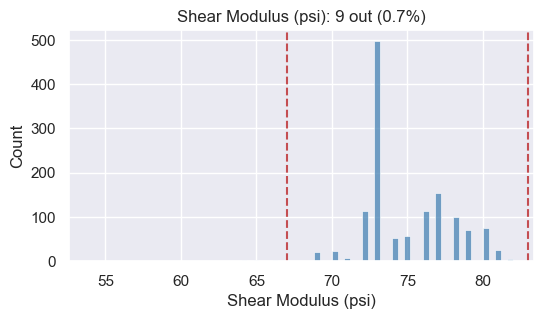

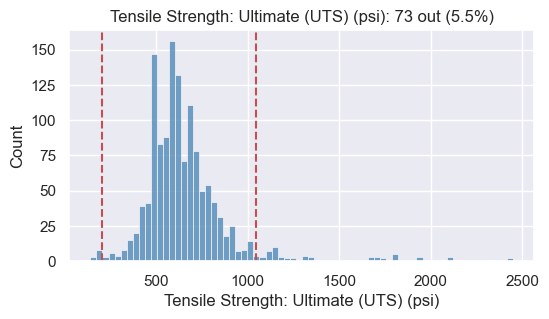

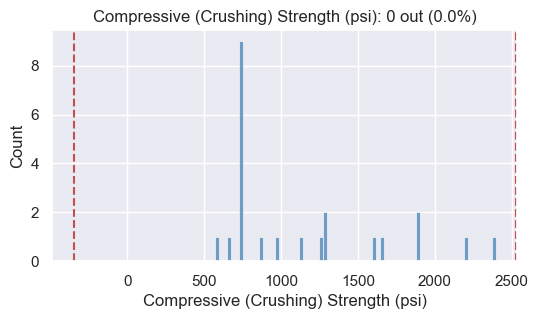

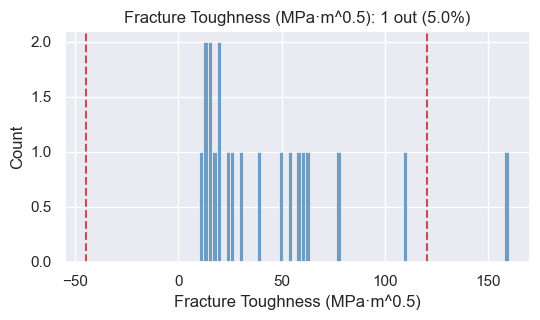

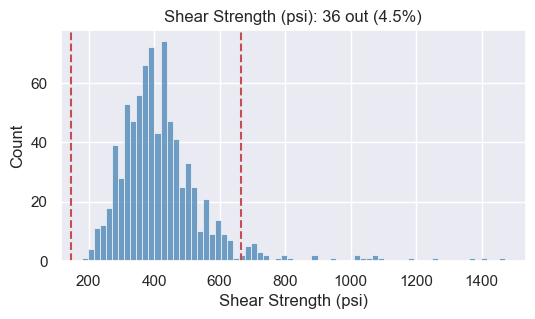

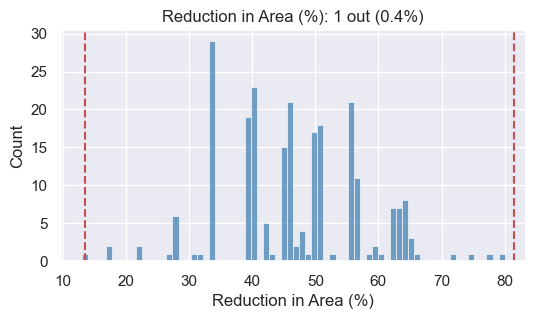

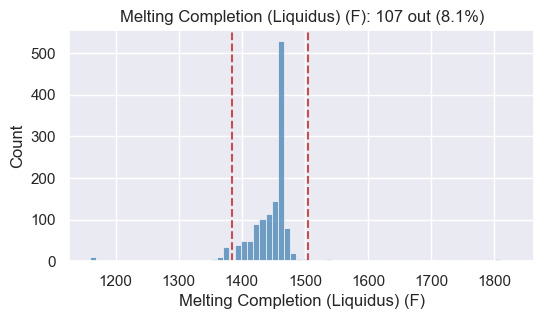

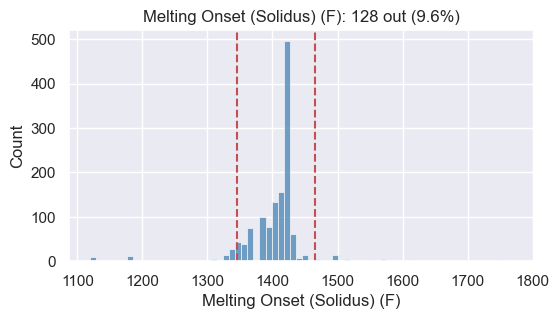

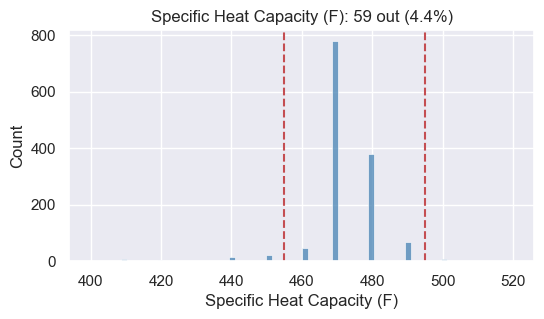

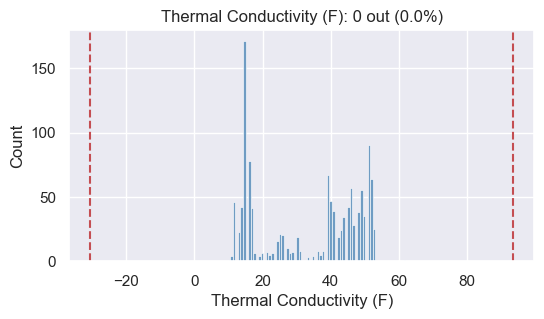

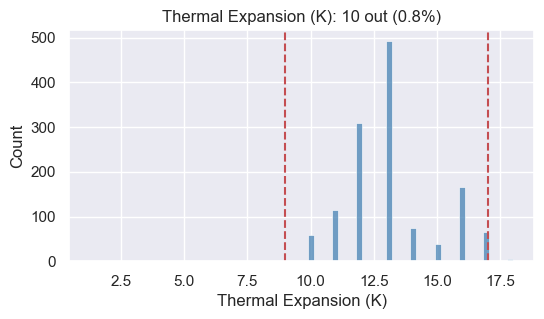

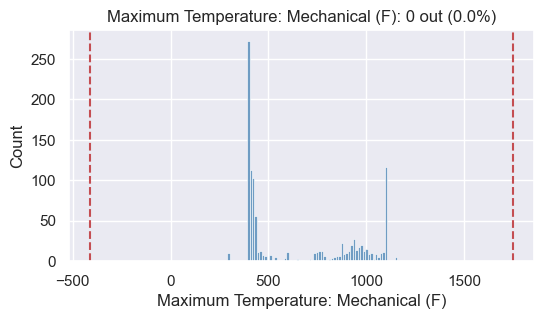

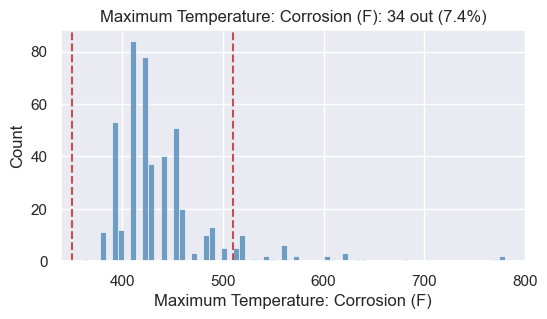

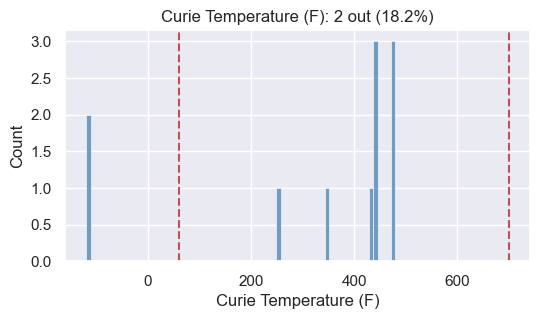

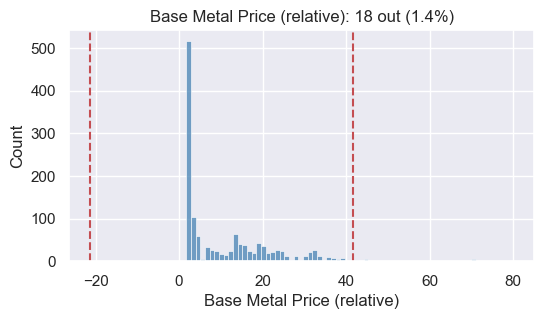

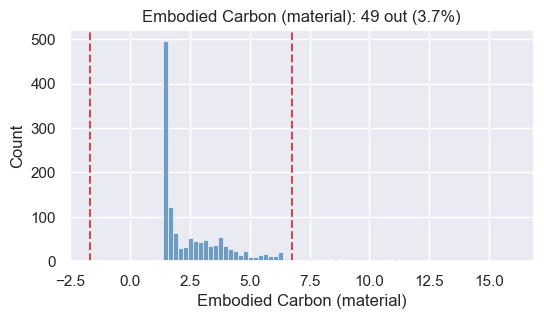

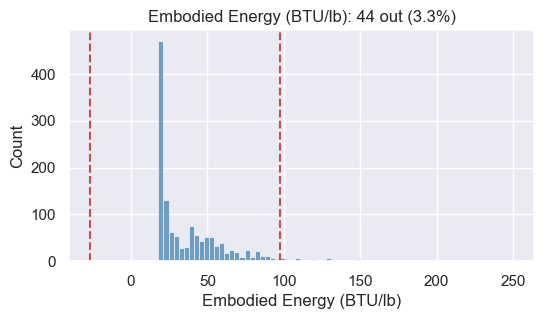

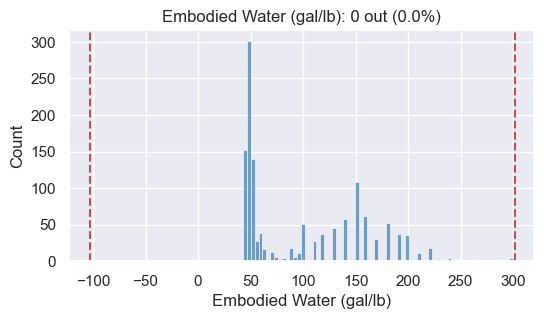

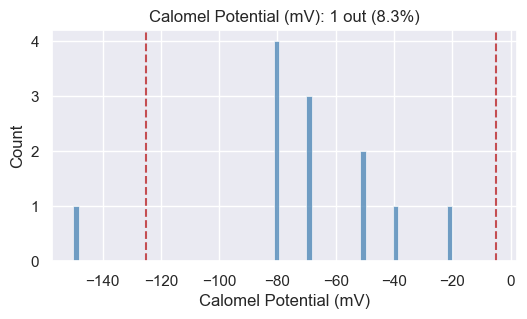

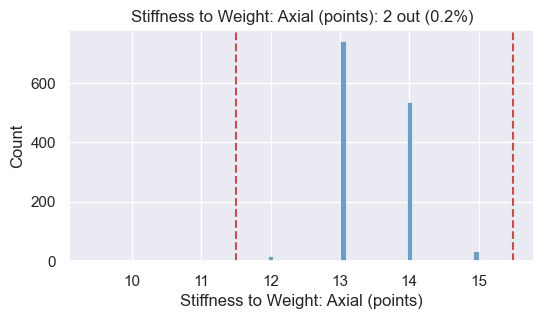

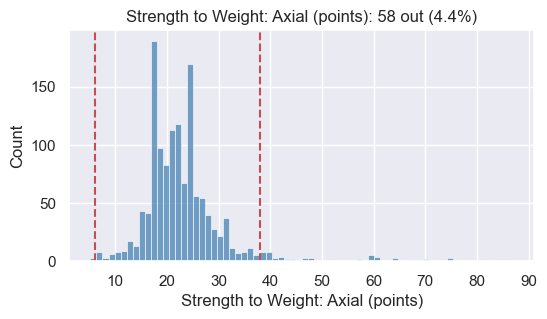

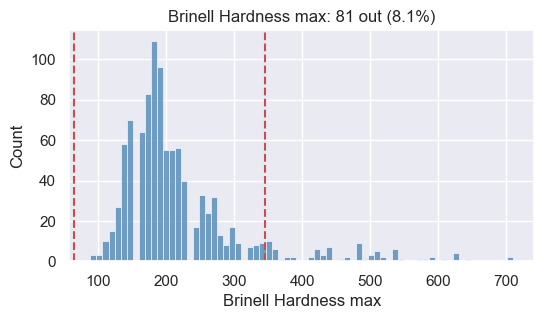

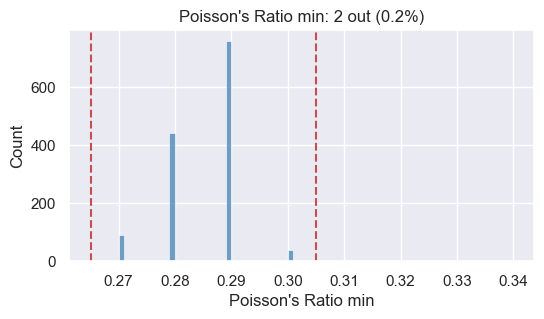

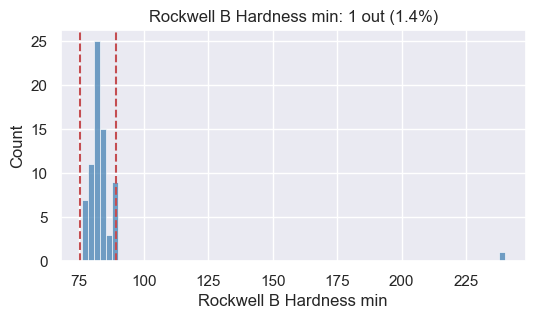

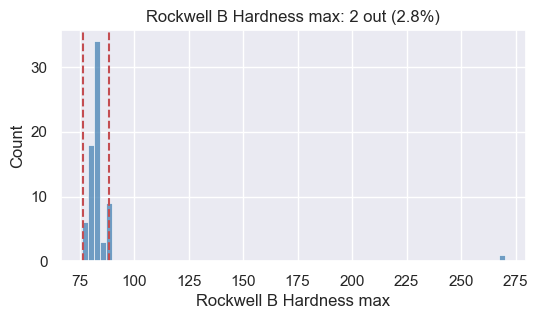

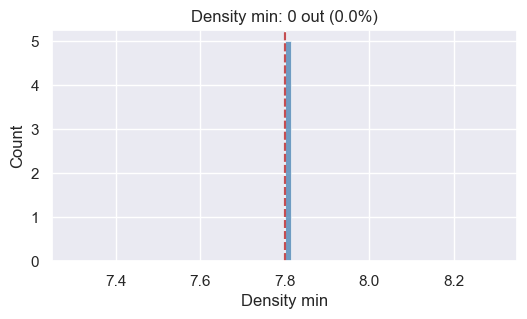

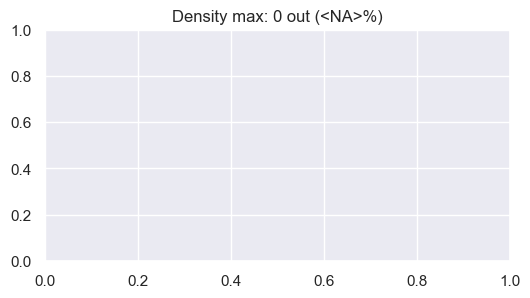

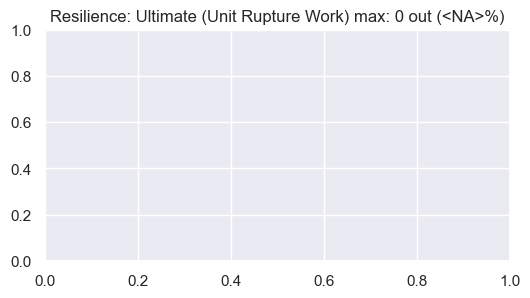

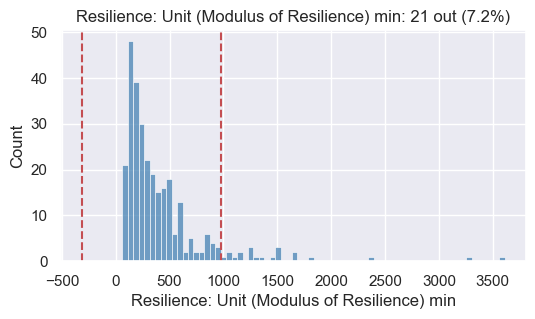

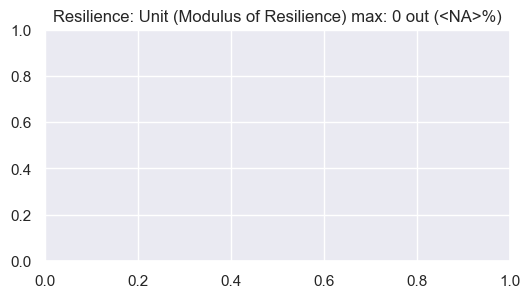

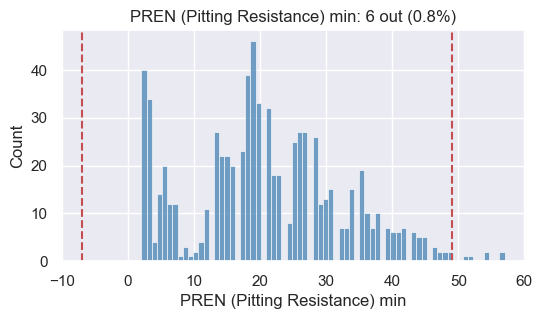

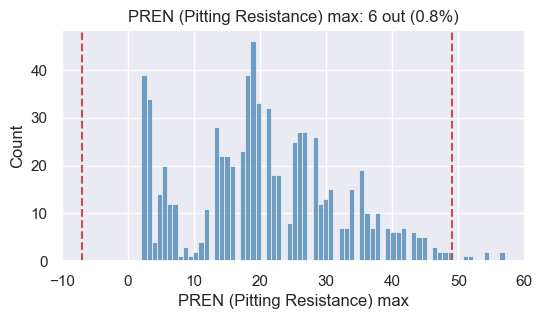

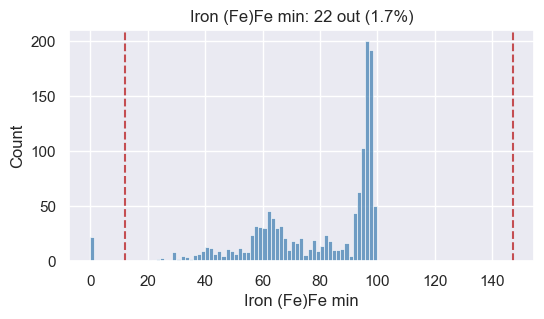

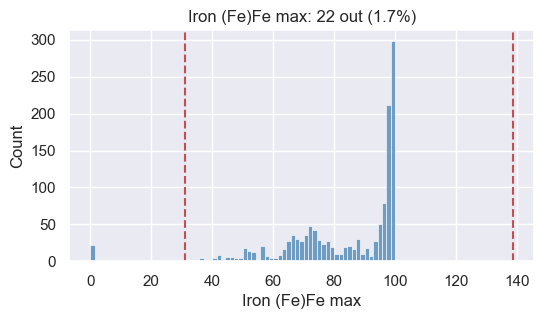

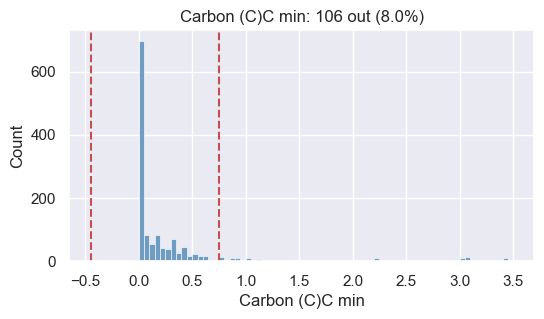

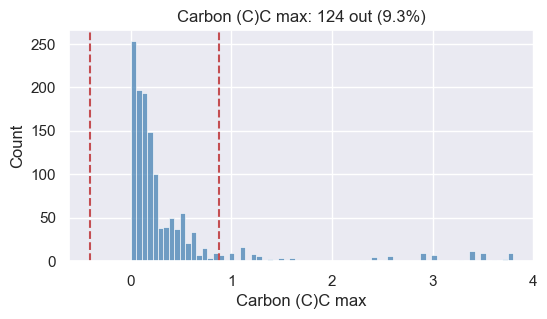

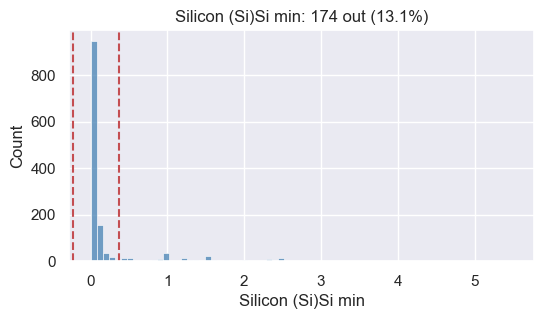

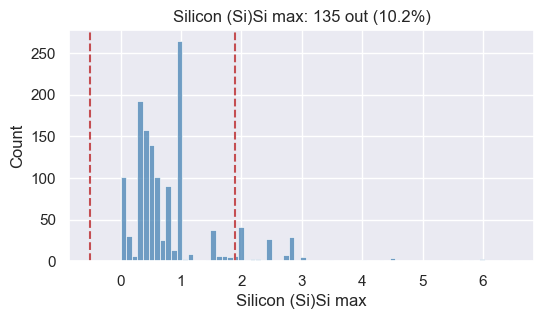

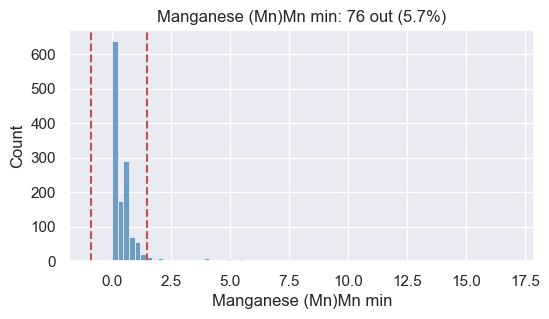

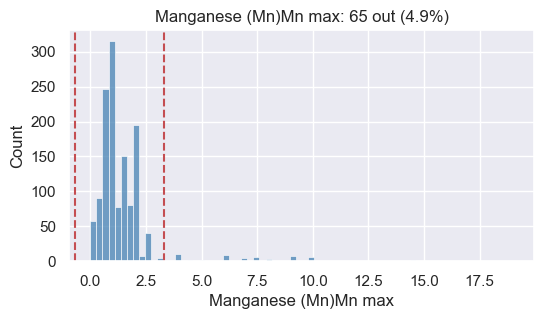

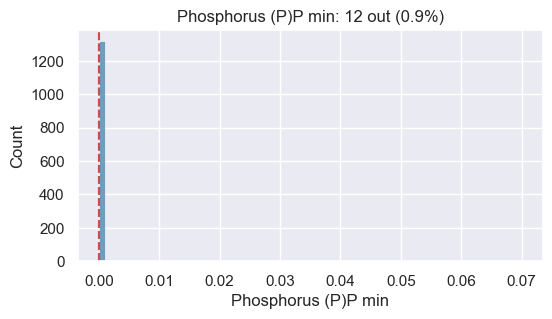

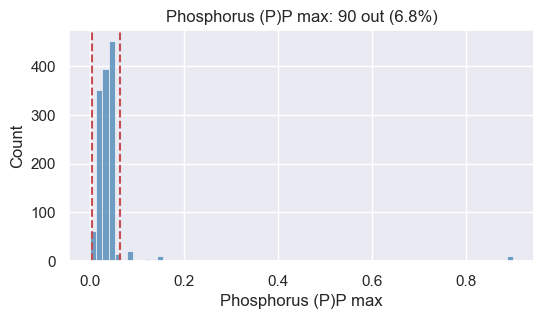

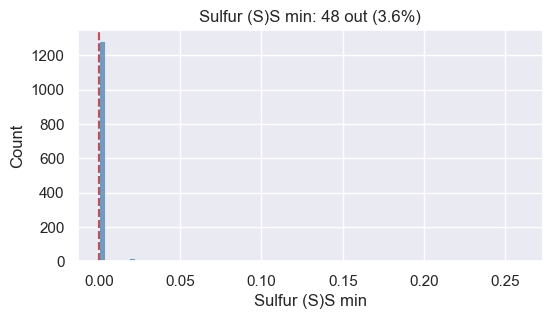

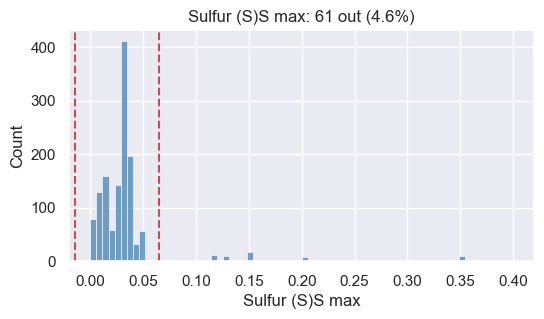

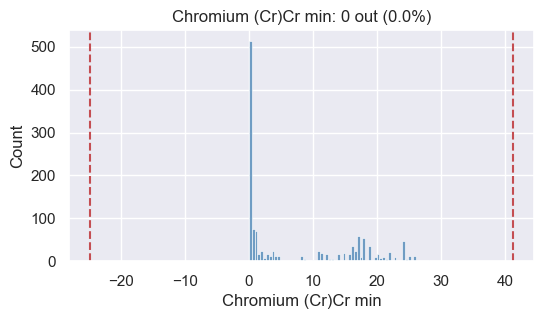

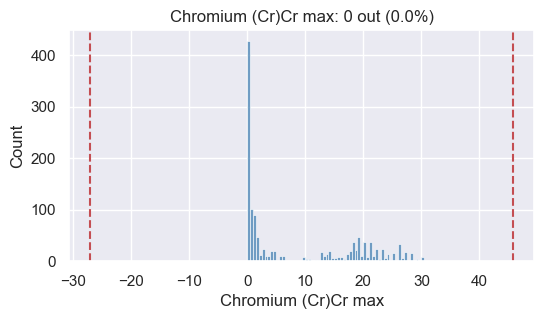

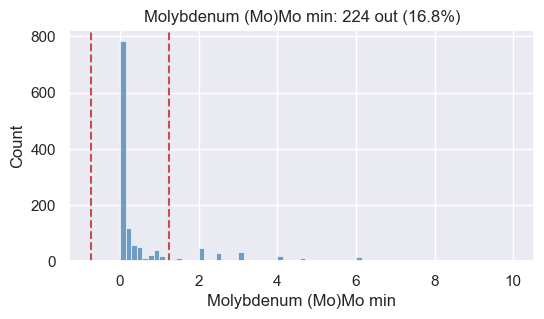

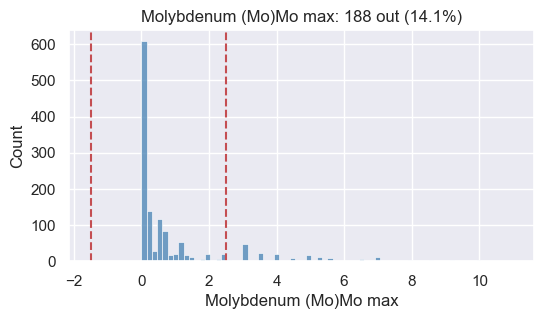

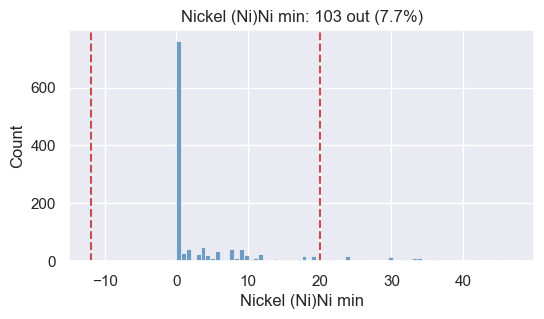

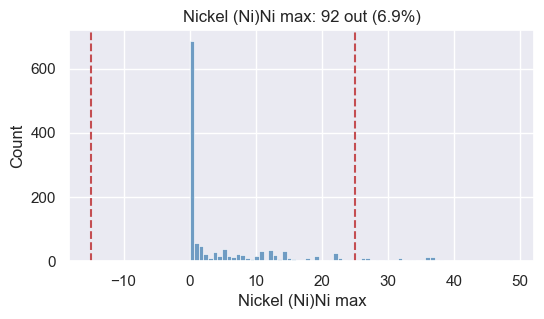

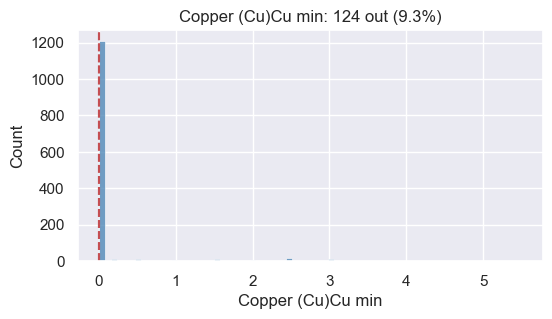

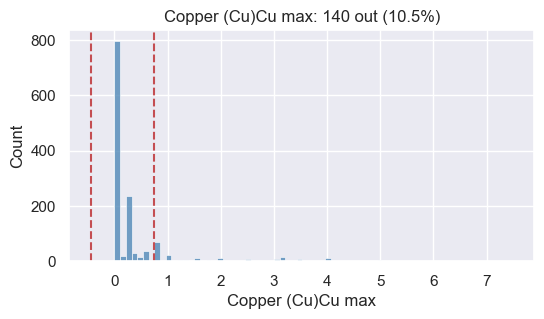

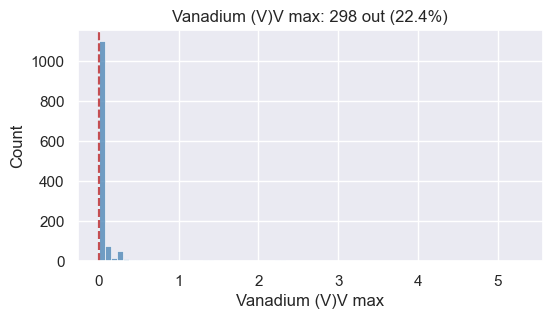

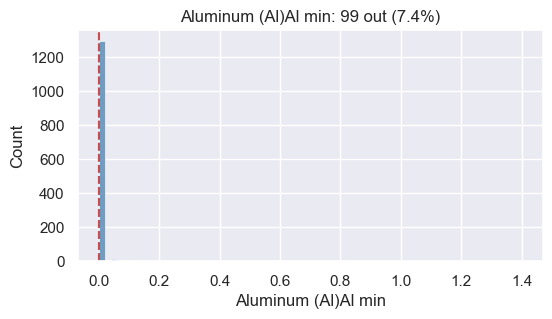

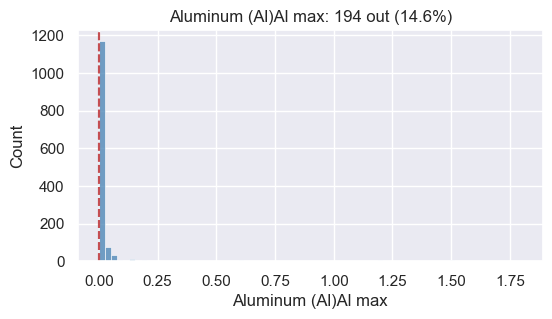

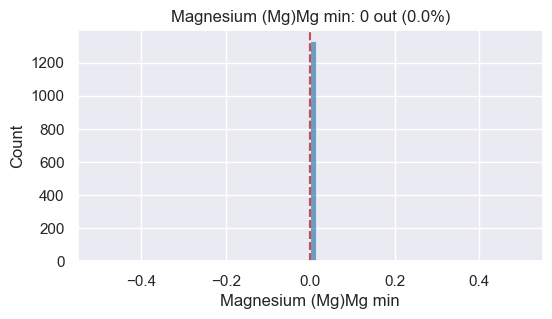

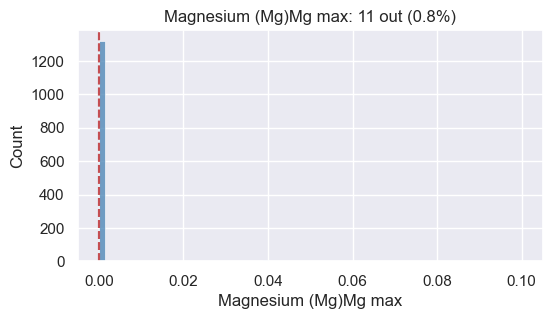

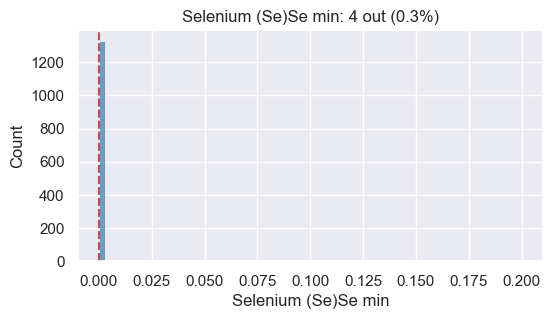

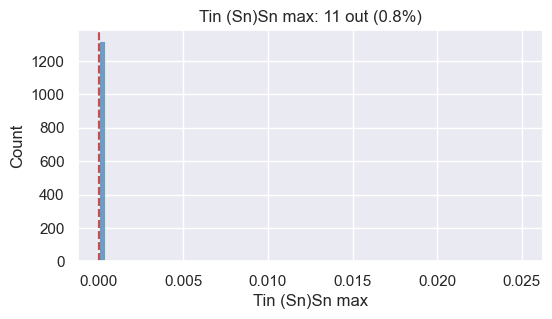

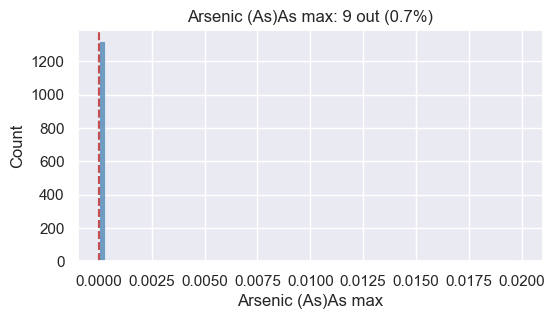

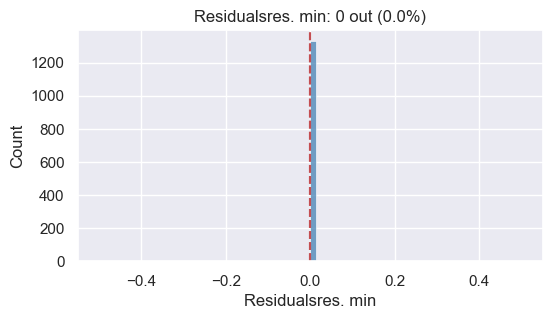

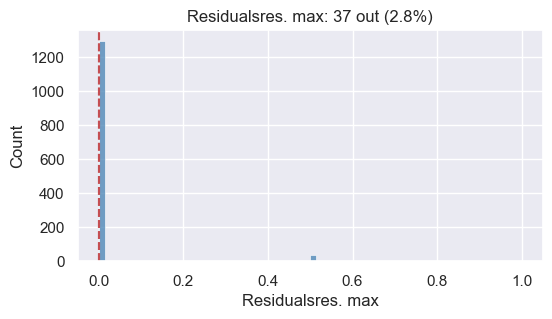

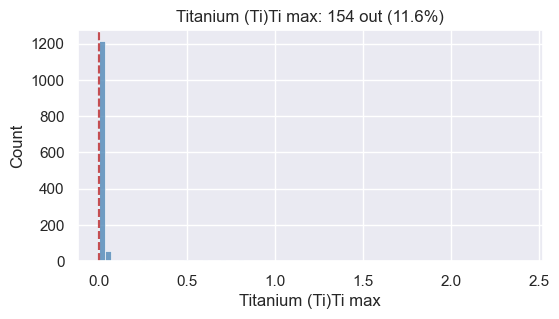

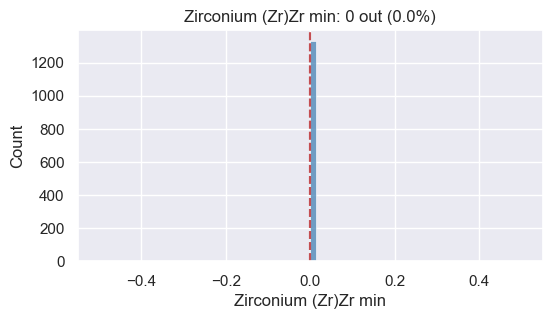

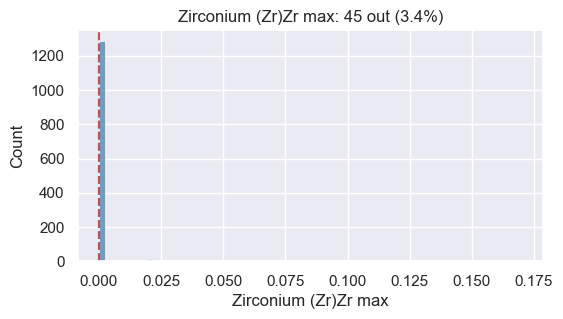

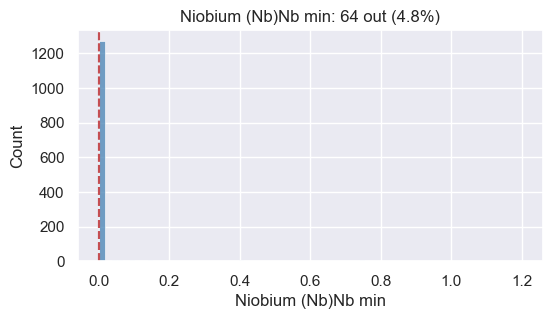

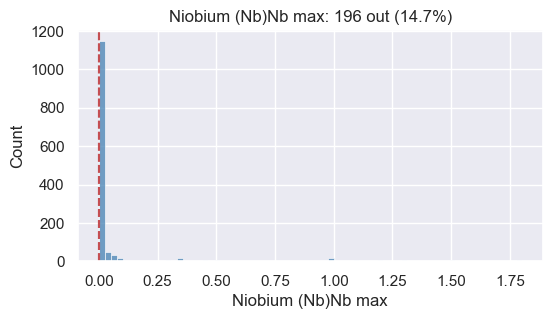

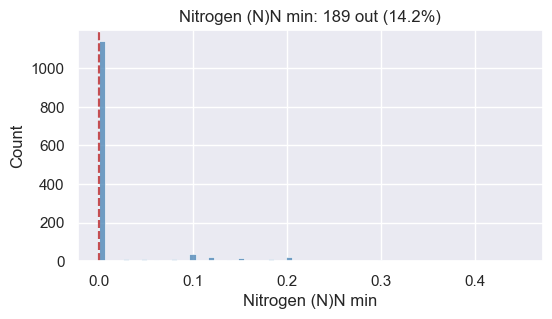

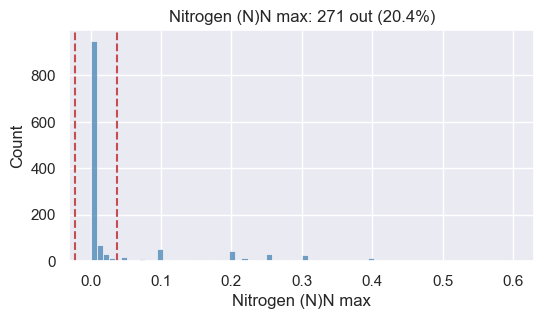

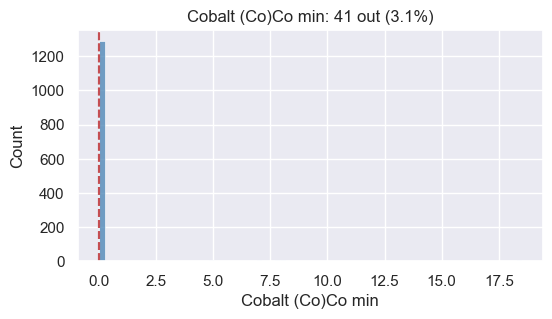

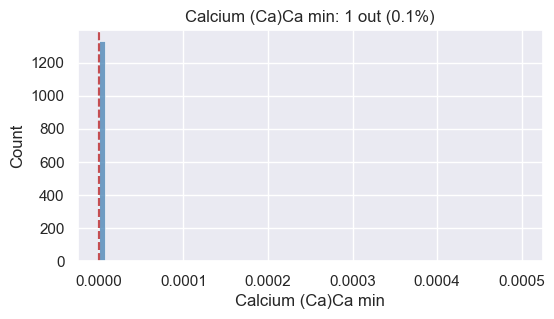

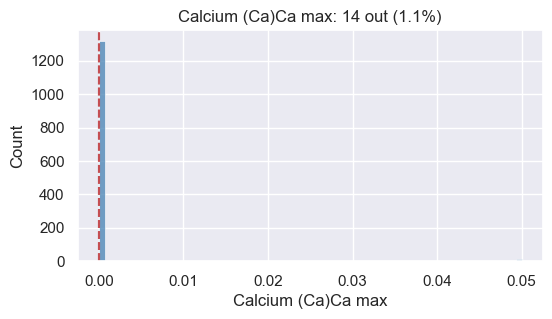

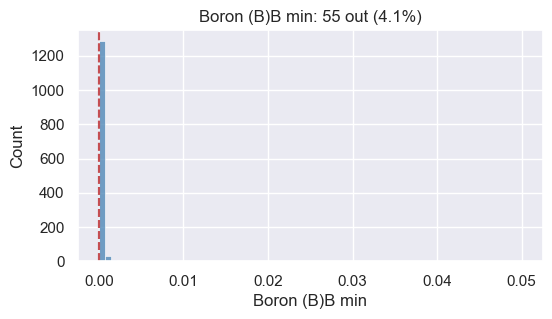

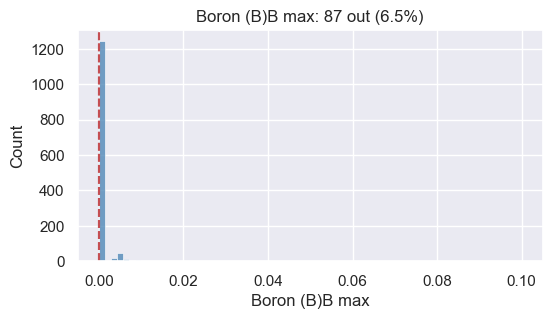

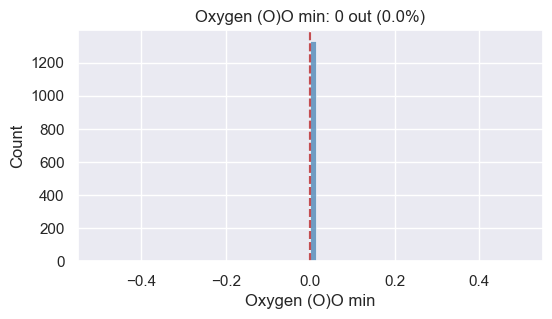

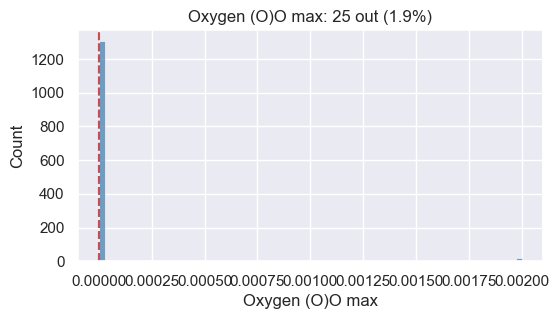

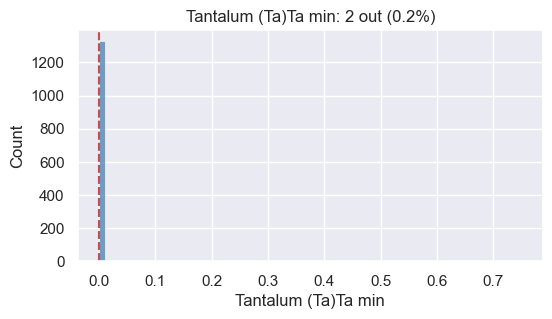

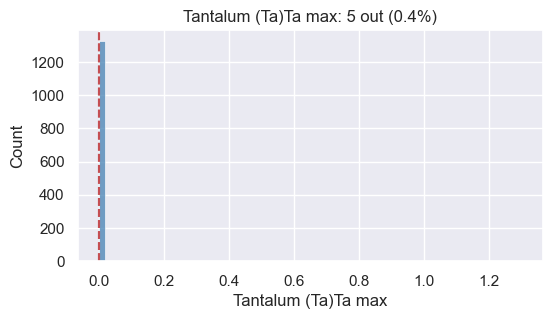

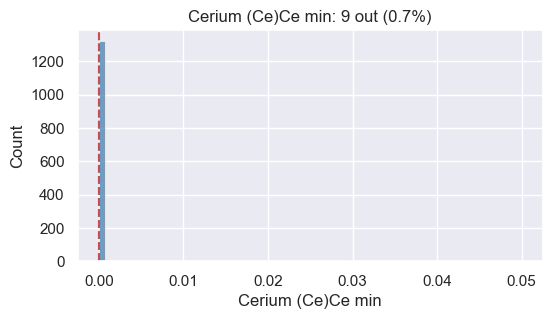

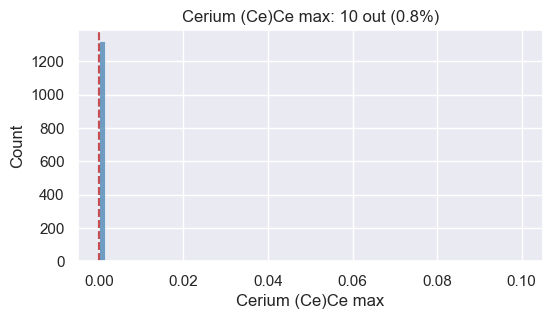

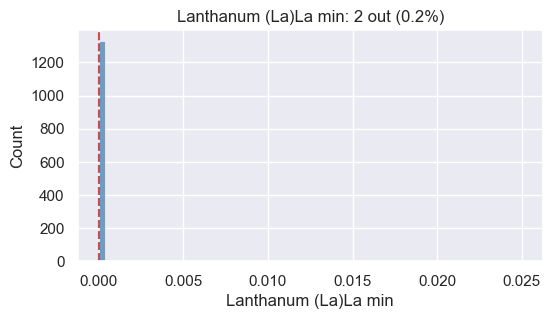

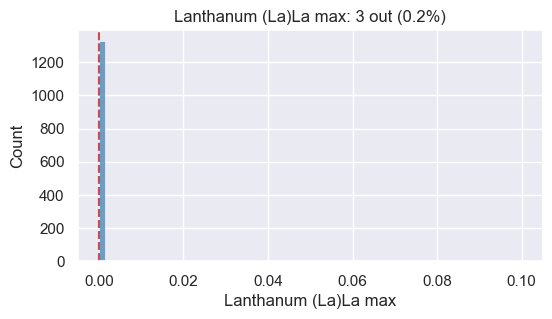

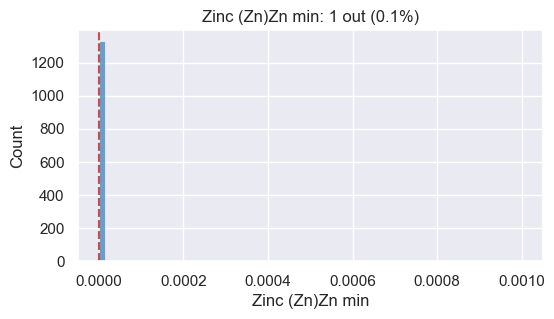

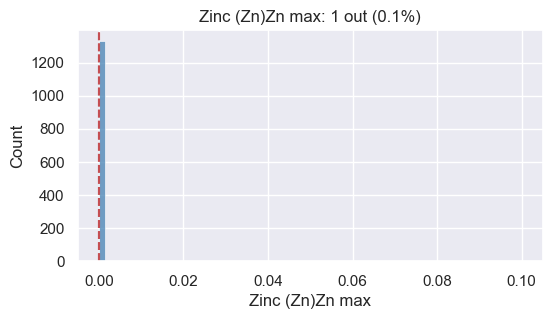

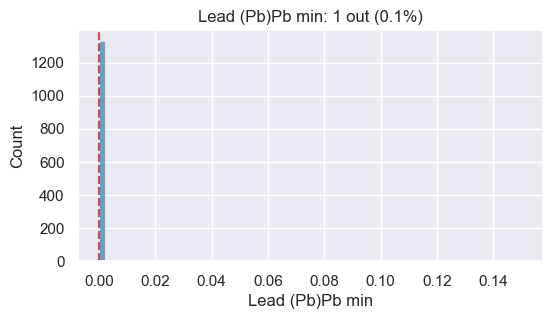

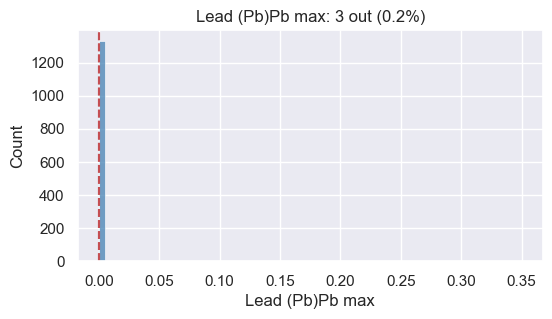

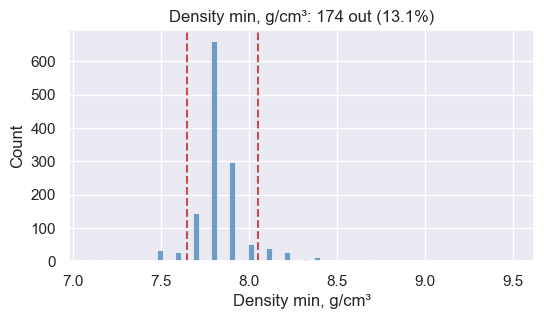

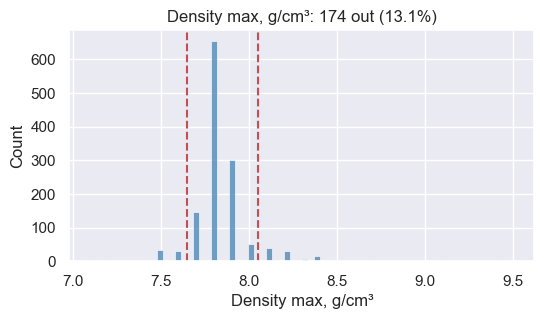

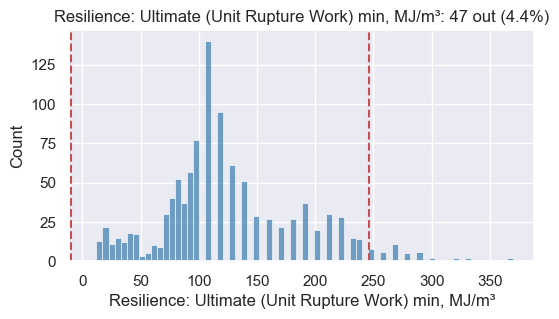

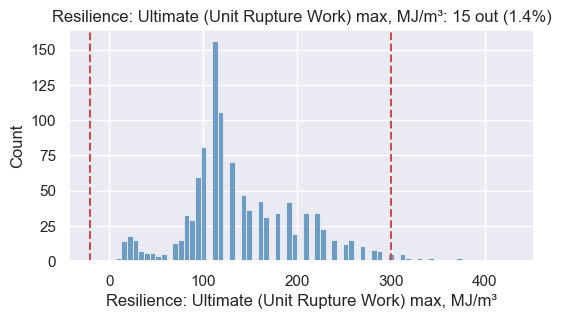

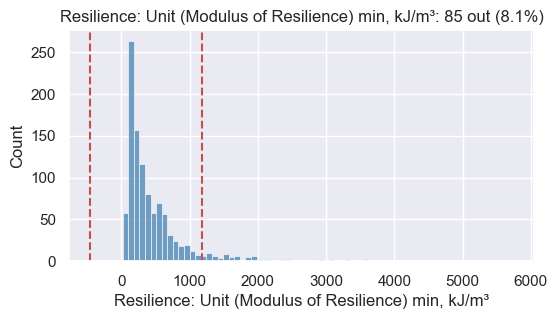

In [120]:
# Построим гистограммы распределений признаков
for col in df_new:                
    s  = df_new[col].dropna()
    st = iqr_stats(s)                     
    plt.figure(figsize=(6,3))
    sns.histplot(s, bins=70, color='steelblue')
    plt.axvline(st['lower'], c='r', ls='--')
    plt.axvline(st['upper'], c='r', ls='--')
    plt.title(f'{col}: {int(st["outliers"])} out ({st["out_%"]:.1f}%)')
    plt.show()

Анализ показал, что присутствуют колонки с разным процентом выбросов. В некоторых из них он довольно высок (н-р, Curie Temperature (F) 18.18% или Nitrogen (N)N max 20.38%), но стоит учитывать физический смысл значений. Высокое/низкое содержание азота или любого другого элемента в некоторых сплавах не является выбросом - это лишь сплав, состава, сильно отличающегося от среднего. Выбросы среди физических свойств сплавов следует рассматривать более тщательно, беря во внимания их состав. Некоторые сплавы действительно могут показывать сильные отличия в физ свойствах, в зависимости от своего состава.

# Корреляция между числовыми признаками

In [121]:

corr = df_new.corr(numeric_only=True)
display(corr.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1))

На тепловой карте открываются интересные корреляции. Например, должно быть, повышенное содержание хрома положительно вляет на модуль сдвига, а высокое содержание алюминия - повышает ударную вязкость. В целом, выявление корреляций необходимо для понимания базовых зависимостей в данных.

# Выводы
1. Датасет содержит 115 количественных признаков
2. Процент пропущенных значений по некоторым столбцам довольно велик, что говорит о необходимости поиска пропущенных значений в публикациях (или проведения исследований, если они не опубликованы). Средняя полнота 0.836, что меньше, чем 0.98, и поэтому является не очень хорошим значением, но довольно ожидаемым для реальных экспериментальных данных.
3. Дубликаты строк были удалены.
4. Исследование выбросов показало присутствие их большого количества в некоторых колонках. В случае колонок, описывающих количественный состав их можно игнорировать - они не являются выбросами, а описывают сплавы с отличным от среднего химическим составом. Случаи выбросов в физических свойствах требуют отдельного внимания, каждый случай требует более глубокого анализа.
5. Корреляционный анализ показал завимости между химическим составом сплава и его физическими свойствами.